# 05 ARIMA

In [2]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

In [3]:
bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')
btc_data = pd.read_csv('data/BTCUSDT_1D_2.csv')

dataSize = len(btc_data)
assert(dataSize == len(bnb_data))
windowSize = 35
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

dataSize: 1421
windowSize: 35
testSize: 426


In [28]:
BTC_FOR_BNB_SCALE = 90
GLOBAL_SCALE = 700

input_data = np.array([[bnb_data["Close"][i]/GLOBAL_SCALE, btc_data["Close"][i]/BTC_FOR_BNB_SCALE/GLOBAL_SCALE] for i in range(len(bnb_data))])

x_train = prepareTrainingInputs(input_data, windowSize, testSize)
y_train = prepareTraingingOutputs(bnb_data["Close"]/GLOBAL_SCALE, windowSize, testSize)
x_test = prepareTestingInputs(input_data, windowSize, testSize)
y_test = prepareTestingOutputs(bnb_data["Close"]/GLOBAL_SCALE, testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train, y_train, x_test, y_test)

In [29]:
neuronCount = 256

input = layers.Input(shape=(windowSize,2), name="stack_input")
x = input
x = tf.keras.layers.LSTM(neuronCount, return_sequences=True)(x)
x = tf.keras.layers.LSTM(neuronCount)(x)
x = tf.keras.layers.Dense(1)(x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stack_input (InputLayer)    [(None, 35, 2)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 35, 256)           265216    
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 790,785
Trainable params: 790,785
Non-trainable params: 0
_________________________________________________________________


In [30]:
model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=["mae", "mse"])

history1 = model1.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            # verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
1/1 [==============================] - 4s 4s/step - loss: 0.3982 - mae: 0.3982 - mse: 0.2456 - val_loss: 4.8813 - val_mae: 4.8813 - val_mse: 24.1873 - lr: 0.0100
Epoch 2/5000
1/1 [==============================] - 0s 136ms/step - loss: 4.4834 - mae: 4.4834 - mse: 24.3830 - val_loss: 0.5233 - val_mae: 0.5233 - val_mse: 0.2781 - lr: 0.0100
Epoch 3/5000
1/1 [==============================] - 0s 131ms/step - loss: 0.5023 - mae: 0.5023 - mse: 0.3411 - val_loss: 1.0338 - val_mae: 1.0338 - val_mse: 1.0830 - lr: 0.0100
Epoch 4/5000
1/1 [==============================] - 0s 132ms/step - loss: 0.9124 - mae: 0.9124 - mse: 1.0980 - val_loss: 1.7381 - val_mae: 1.7381 - val_mse: 3.0289 - lr: 0.0100
Epoch 5/5000
1/1 [==============================] - 0s 134ms/step - loss: 1.5925 - mae: 1.5925 - mse: 2.6649 - val_loss: 1.2264 - val_mae: 1.2264 - val_mse: 1.5204 - lr: 0.0100
Epoch 6/5000
1/1 [==============================] - 0s 140ms/step - loss: 0.9314 - mae: 0.9314 - mse: 1.3922 - val_l

14/14 [==============================] - 0s 12ms/step - loss: 0.0082 - mae: 0.0082 - mse: 1.5466e-04
rmse1: 8.705226804139953
corr: 0.9777685702927171


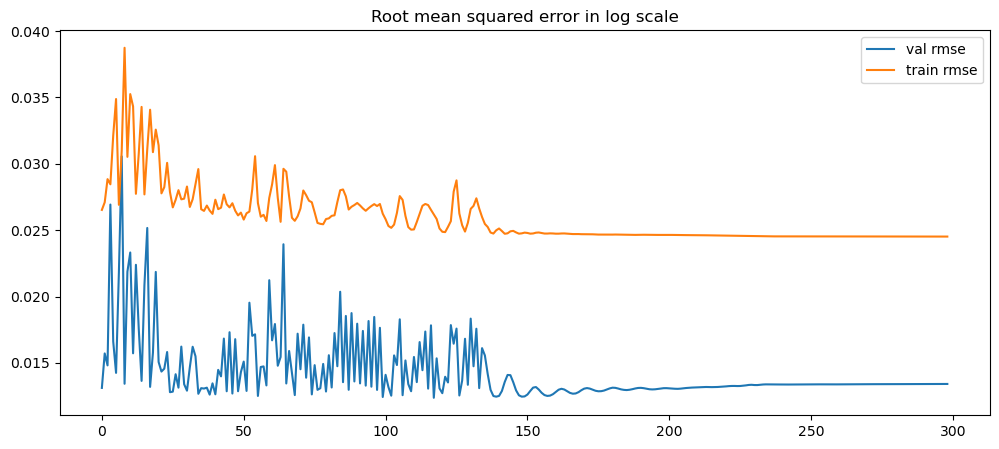

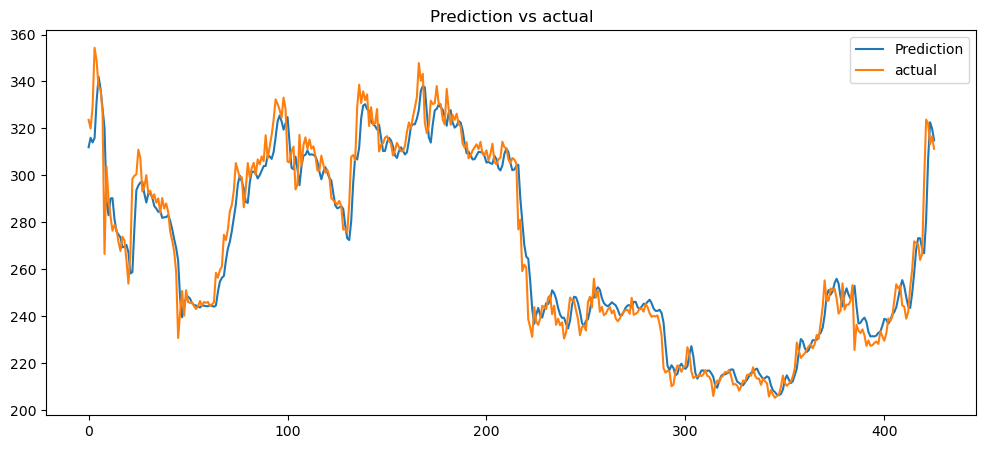

In [41]:
rmse1 = np.sqrt(model1.evaluate(np.array(x_test), y_test)[2]) * GLOBAL_SCALE
print(f"rmse1: {rmse1}")

# plot error
plt.figure(figsize=(12, 5))
plotHistoryRSME(history1, 300)

# plot prediction
prediction1 = model1.predict(np.array(x_test)) * GLOBAL_SCALE
plt.figure(figsize=(12, 5))
plt.plot(prediction1, label='Prediction')
plt.plot(y_test * GLOBAL_SCALE, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr1 = np.corrcoef(prediction1.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr1}")